<h2>Setup</h2>


For Setup, make

- read_data
- load_datasets
- compute_bounds
- plot_decision_surface
- plot_learning_curves
- compute_accuracy

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# imports and utilities
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Dict, List
from matplotlib.colors import ListedColormap

%matplotlib inline

# set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(0)

DEVICE = torch.device('cpu')
K_CANDIDATES = [2, 3, 5, 7, 9] 
DATASETS = ['xor', 'center_surround', 'two_gaussians', 'spiral']

# Data loading utilities
def read_data (name: str, mode: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Load datasets from CSV files"""
    x_data, y_data, label_data = [], [], []  # label data not needed for cross entropy loss
    filename = f'{name}_{mode}.csv'

    with open(filename, 'rt') as f:
        for i, line in enumerate(f):
            if i == 0: # skip header
                continue
            tokens = line.strip().split(',') #string
            y = int(float(tokens[0]))
            x1, x2 = float(tokens[1]), float(tokens[2])
            x_data.append([x1, x2])
            y_data.append(y)
            label = [0, 0]
            label[y] = 1
            label_data.append(label)

    return (
        np.array(x_data, dtype='float32'),
        np.array(y_data, dtype='int64'),
        np.array(label_data, dtype='float32')
    )


def load_datasets(name:str) -> Dict[str, Tuple[torch.Tensor, torch.Tensor]]:
    """Load train, validation, and test data sets"""
    datasets = {}
    for mode in ['train', 'valid', 'test']:
        X, y, _ = read_data(name, mode)
        datasets[mode] = (torch.tensor(X, dtype=torch.float32), 
                          torch.tensor(y, dtype=torch.long))
    return datasets


# Plotting utilities
def compute_bounds (features: np.ndarray) -> Tuple[float, float, float, float]:
    """Compute axis bounds for plotting"""
    min1, max1 = features[:, 0].min()-1, features[:, 0].max()+1
    min2, max2 = features[:, 1].min()-1, features[:, 1].max()+1

    return (min1, max1, min2, max2)


def plot_decision_surface(X: np.ndarray, y:np.ndarray, model, 
                          bounds: Tuple[float, float, float, float], 
                          title: str='Decision Surface'):
    
    min1, max1, min2, max2 = bounds
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    xx, yy = np.meshgrid(x1grid, x2grid)

    grid = np.c_[xx.ravel(), yy.ravel()]
    predictions = model.predict(grid)
    zz = predictions.reshape(xx.shape)

    fig, ax = plt.subplots(figsize=(6,5))
    cmap = ListedColormap(['#9ce8ff', '#ffc773'])
    ax.contourf(xx, yy, zz, cmap=cmap, alpha=0.7) # colormap

    # Plot data points
    neg_idx = np.where(y < 0.5)[0]
    pos_idx = np.where(y > 0.5)[0]
    ax.scatter(X[neg_idx, 0], X[neg_idx, 1], label='Class 0', marker='o') # (x1, x2)
    ax.scatter(X[pos_idx, 0], X[pos_idx, 1], label='Class 1', marker='^')

    ax.set_title(title)
    ax.set_xlim(min1, max1)
    ax.set_ylim(min2, max2)
    ax.legend()
    plt.tight_layout()
    plt.show()


def plot_learning_curves(train_losses: List[float], valid_losses: List[float], 
                         title: str = 'Learning Curves'):
    """Plot training and validation loss curves."""
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(train_losses, label='Train Loss')
    ax.plot(valid_losses, label='Valid Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def compute_accuracy(predictions: np.ndarray, targets: np.ndarray) -> float:
    """Compute classification accuracy"""
    return np.mean(predictions == targets)


print("Set up complete. Found datasets:", DATASETS)
print("Hypereparameter search will use k=", K_CANDIDATES)

Set up complete. Found datasets: ['xor', 'center_surround', 'two_gaussians', 'spiral']
Hypereparameter search will use k= [2, 3, 5, 7, 9]


<h1>Multi-layer Perceptrons w/ MCE<h1>

In [8]:
## MLP with Multi-class Cross Entropy

class MLP(nn.Module):
    """Multi-layer Perceptron for classification with Cross Entropy loss"""
    def __init__(self, input_dim:int, hidden_dim: int, num_classes: int=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias = True)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, num_classes, bias = True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.activation(self.fc1(x))
        logits = self.fc2(h)
        return logits
    

def train_mce(datasets: Dict, hidden_dim: int, lr: float=0.01, 
              epochs: int = 500, batch_size: int = 32) -> Tuple:
    """Train MLP with MCE loss"""
    X_train, y_train = datasets['train']
    X_valid, y_valid = datasets['valid']

    model = MLP(input_dim=2, hidden_dim=hidden_dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, valid_losses = [], []
    n = X_train.shape[0]

    for epoch in range(epochs):
        # Training
        model.train()
        indices = torch.randperm(n) # shuffling

        for i in range(0, n, batch_size):
            batch_idx = indices[i:min(i+batch_size, n)]
            X_batch = X_train[batch_idx]
            y_batch = y_train[batch_idx]

            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            train_loss = criterion(model(X_train), y_train).item()
            valid_loss = criterion(model(X_valid), y_valid).item()
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

    return model, train_losses, valid_losses


def evaluate_mce(model: MLP, X: torch.Tensor, y: torch.Tensor) -> float:
    """Evaluate accuracy of MCE model"""
    model.eval()
    with torch.no_grad():
        logits = model(X)
        predictions = torch.argmax(logits, dim=1)
        accuracy = (predictions == y).float().mean().item()
    return accuracy


class MCEWrapper:
    """Wrapper for plotting decisoin surfaces"""
    def __init__(self, model:MLP):
        self.model = model
        self.model.eval()

    def predict(self, X:np.ndarray) -> np.ndarray:
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            logits = self.model(X_tensor)
            predictions = torch.argmax(logits, dim=1).numpy()
        return predictions

MLP with Multi-class Cross Entropy

Dataset: XOR

Training with k=2 hidden nodes...
Validation accuracy: 0.7050

Training with k=3 hidden nodes...
Validation accuracy: 0.8700

Training with k=5 hidden nodes...
Validation accuracy: 0.9600

Training with k=7 hidden nodes...
Validation accuracy: 0.9600

Training with k=9 hidden nodes...
Validation accuracy: 0.9750

************************************************************
BEST k=9 | Valid Acc: 0.9750 | Test Acc: 0.9750
************************************************************


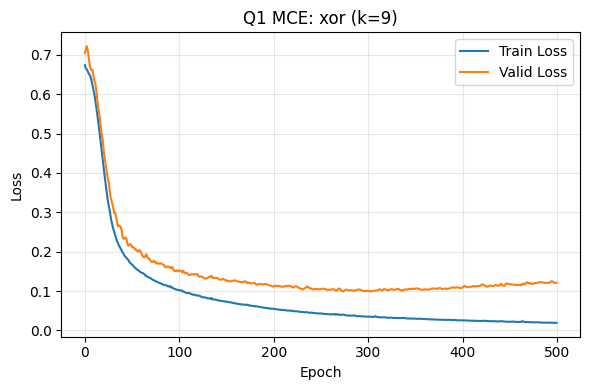

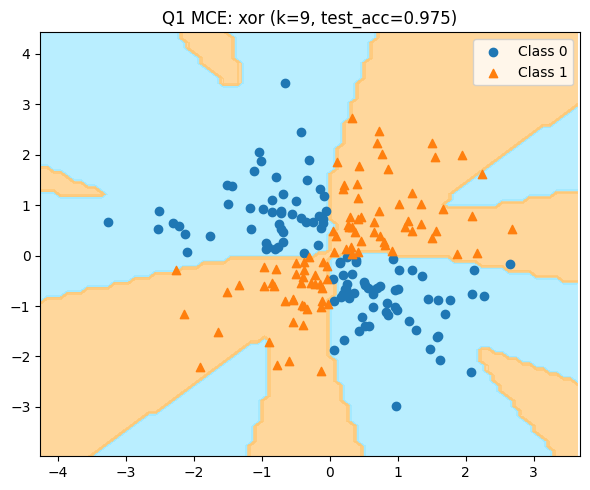


Dataset: CENTER_SURROUND

Training with k=2 hidden nodes...
Validation accuracy: 0.8800

Training with k=3 hidden nodes...
Validation accuracy: 0.9500

Training with k=5 hidden nodes...
Validation accuracy: 0.9550

Training with k=7 hidden nodes...
Validation accuracy: 0.9600

Training with k=9 hidden nodes...
Validation accuracy: 0.9600

************************************************************
BEST k=7 | Valid Acc: 0.9600 | Test Acc: 0.7600
************************************************************


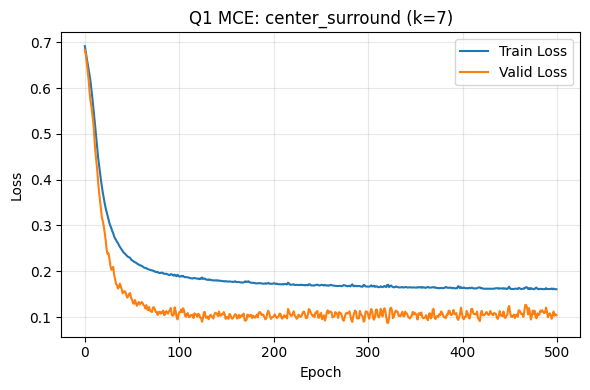

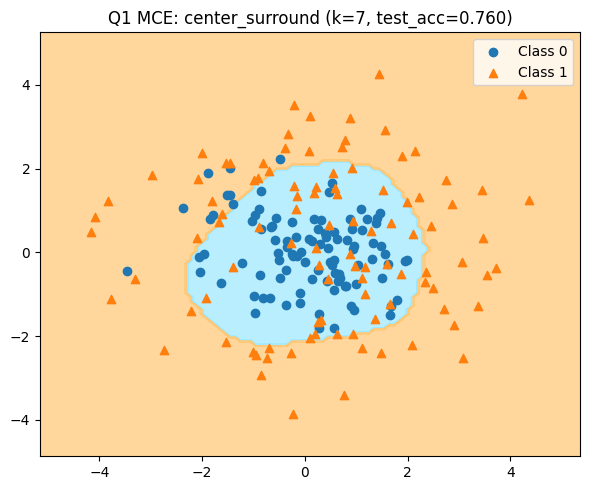


Dataset: TWO_GAUSSIANS

Training with k=2 hidden nodes...
Validation accuracy: 0.9800

Training with k=3 hidden nodes...
Validation accuracy: 0.9750

Training with k=5 hidden nodes...
Validation accuracy: 0.9750

Training with k=7 hidden nodes...
Validation accuracy: 0.9750

Training with k=9 hidden nodes...
Validation accuracy: 0.9800

************************************************************
BEST k=2 | Valid Acc: 0.9800 | Test Acc: 0.9150
************************************************************


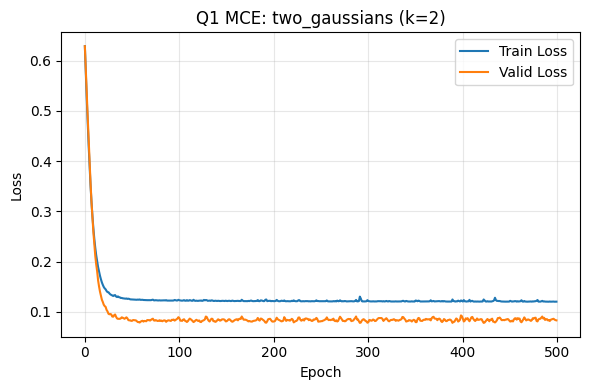

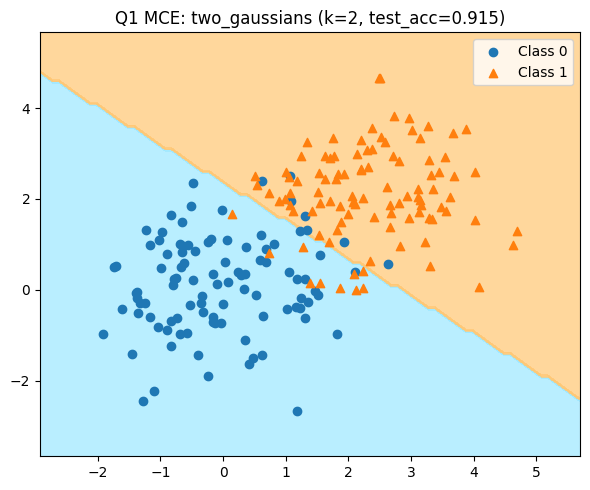


Dataset: SPIRAL

Training with k=2 hidden nodes...
Validation accuracy: 0.7050

Training with k=3 hidden nodes...
Validation accuracy: 0.7450

Training with k=5 hidden nodes...
Validation accuracy: 0.9100

Training with k=7 hidden nodes...
Validation accuracy: 0.9550

Training with k=9 hidden nodes...
Validation accuracy: 0.9800

************************************************************
BEST k=9 | Valid Acc: 0.9800 | Test Acc: 1.0000
************************************************************


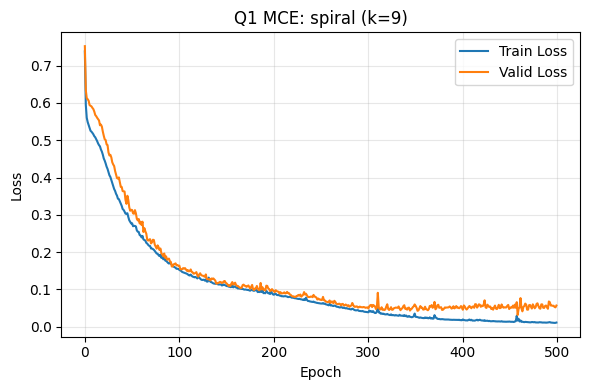

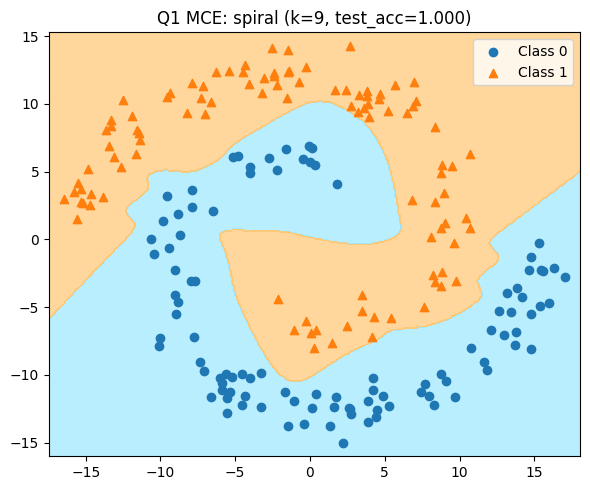


Q1 SUMMARY
xor                  | k=9 | Test Acc: 0.9750
center_surround      | k=7 | Test Acc: 0.7600
two_gaussians        | k=2 | Test Acc: 0.9150
spiral               | k=9 | Test Acc: 1.0000


In [27]:
### Experiment ###]
print("=" * 60)
print("MLP with Multi-class Cross Entropy")
print("=" * 60)

q1_results = {}

for dataset_name in DATASETS:
    print(f"\n{'='*60}")
    print(f"Dataset: {dataset_name.upper()}")
    print(f"{'='*60}")

    datasets = load_datasets(dataset_name)
    X_test, y_test = datasets['test']

    best_k = None
    best_valid_acc = 0.0
    best_model = None
    best_train_losses = None
    best_valid_losses = None

    # Search over k values
    for k in K_CANDIDATES:
        print(f"\nTraining with k={k} hidden nodes...")
        model, train_losses, valid_losses = train_mce(
            datasets, hidden_dim=k, lr=0.01, epochs=500, batch_size=32
        )

        valid_acc = evaluate_mce(model, *datasets['valid']) #(model, X_valid, y_valid)
        print(f"Validation accuracy: {valid_acc:.4f}")

        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_k = k
            best_model = model
            best_train_losses = train_losses
            best_valid_losses = valid_losses

    # Evaluate best model on test set
    test_acc = evaluate_mce(best_model, X_test, y_test)

    print(f"\n{'*'*60}")
    print(f"BEST k={best_k} | Valid Acc: {best_valid_acc:.4f} | Test Acc: {test_acc:.4f}")
    print(f"{'*'*60}")

    # Plot learning curves
    plot_learning_curves(
        best_train_losses, best_valid_losses,
        title=f'Q1 MCE: {dataset_name} (k={best_k})'
    )

    # Plot decision surface
    X_test_np = X_test.numpy()
    y_test_np = y_test.numpy()
    bounds = compute_bounds(X_test_np)
    wrapper = MCEWrapper(best_model)
    plot_decision_surface(
        X_test_np, y_test_np, wrapper, bounds,
        title=f'Q1 MCE: {dataset_name} (k={best_k}, test_acc={test_acc:.3f})'
    )

    q1_results[dataset_name] = {
        'best_k': best_k,
        'valid_acc': best_valid_acc,
        'test_acc': test_acc
    }

print("\n" + "="*60)
print("Q1 SUMMARY")
print("="*60)
for name, result in q1_results.items():
    print(f"{name:20s} | k={result['best_k']} | Test Acc: {result['test_acc']:.4f}")

<h1>Manual Gradients (No Deep Learning Platform)</h1>

In [5]:
# one hidden layer, mse

class ManualMLP:
    """MLP with manual gradient computation"""
    def __init__(self, input_dim: int, hidden_dim: int, learning_rate: float=0.1):
        self.lr = learning_rate

        # Initialize weights with small random values
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.1
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, 1) * 0.1
        self.b2 = np.zeros(1)

    @staticmethod
    def tanh(x):
        return np.tanh(x)
    
    @staticmethod
    def tanh_derivative(x):
        return 1.0 - np.tanh(x) ** 2
    
    @staticmethod
    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-np.clip(x, -500, 500)))
    
    @staticmethod
    def sigmoid_derivative(x):
        s = ManualMLP.sigmoid(x)
        return s * (1.0 - s)
    
    def forward(self, X: np.ndarray) -> Tuple:
        """Forward pass. Returns intermediate values for backprop"""
        # Hidden layer
        z1 = X @ self.W1 + self.b1  #linear
        h = self.tanh(z1)  #activation

        # Output layer
        z2 = h @ self.W2 + self.b2  #linear
        y_pred = self.sigmoid(z2)   #activation

        return y_pred, h, z1, z2
    
    def backward(self, X: np.ndarray, y: np.ndarray, y_pred: np.ndarray,
                 h: np.ndarray, z1: np.ndarray, z2: np.ndarray):
        """Backward pass with manual gradient computation"""
        n = X.shape[0]


        # Output layer gradients (MSE loss)
        # dL/dy_pred = 2 * (y_pred - y)
        # dy_pred/dz2 = sigmoid'(z2)
        dL_dz2 = 2 * (y_pred - y.reshape(-1, 1)) * self.sigmoid_derivative(z2)
        dL_dW2 = (h.T @ dL_dz2) / n
        dL_db2 = np.mean(dL_dz2, axis = 0)

        # Hidden layer gradients
        # dL/dh = dL/dz2 * dz2/dh = dL/dz2 * W2^T
        # dL/dz1 = dL/dh * dh/dz1 = dL/dh * tanh'(z1)
        dL_dh = dL_dz2 @ self.W2.T
        dL_dz1 = dL_dh * self.tanh_derivative(z1)
        dL_dW1 = (X.T @ dL_dz1) / n
        dL_db1 = np.mean(dL_dz1, axis=0)

        # Update weights
        self.W2 -= self.lr * dL_dW2
        self.b2 -= self.lr * dL_db2
        self.W1 -= self.lr * dL_dW1
        self.b1 -= self.lr * dL_db1

    def train_step(self, X: np.ndarray, y:np.ndarray) -> float:
        """Single training step. Retunrs loss"""
        y_pred, h, z1, z2 = self.forward(X)
        loss = np.mean((y_pred.flatten() - y) ** 2) #mse
        self.backward(X, y, y_pred, h, z1, z2)
        return loss
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions"""
        y_pred, _, _, _ = self.forward(X) 
        return (y_pred.flatten() > 0.5).astype(int)
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Get probability predictions"""
        y_pred, _, _, _ = self.forward(X) 
        return y_pred.flatten()
    

def train_manual_mlp(X_train: np.ndarray, y_train: np.ndarray,
                     X_valid: np.ndarray, y_valid: np.ndarray,
                     hidden_dim: int = 5, lr: float = 0.1, epochs: int = 1000):
    """Train manual MLP and track losses"""
    model = ManualMLP(input_dim=2, hidden_dim=hidden_dim, learning_rate=lr)
    train_losses, valid_losses = [], []

    for epoch in range(epochs):
        # Training loss
        train_loss = model.train_step(X_train, y_train)

        # Validation loss
        y_valid_pred = model.predict_proba(X_valid)
        valid_loss = np.mean((y_valid_pred - y_valid) ** 2)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if (epoch + 1) % 200 == 0:
            print(f"EPoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}")

    return model, train_losses, valid_losses

class ManualMLPWrapper:
    """Wrapper for plotting"""
    def __init__(self, model: ManualMLP):
        self.model = model

    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.model.predict(X)
    
    

QUESTION 3: Manual Gradients on XOR Dataset

Training manual MLP with k=5 hidden nodes...
EPoch 200/1000 | Train Loss: 0.2432 | Valid Loss: 0.2593
EPoch 400/1000 | Train Loss: 0.2417 | Valid Loss: 0.2603
EPoch 600/1000 | Train Loss: 0.2408 | Valid Loss: 0.2610
EPoch 800/1000 | Train Loss: 0.2399 | Valid Loss: 0.2616
EPoch 1000/1000 | Train Loss: 0.2386 | Valid Loss: 0.2615

************************************************************
Manual MLP Test Accuracy: 0.6000
************************************************************


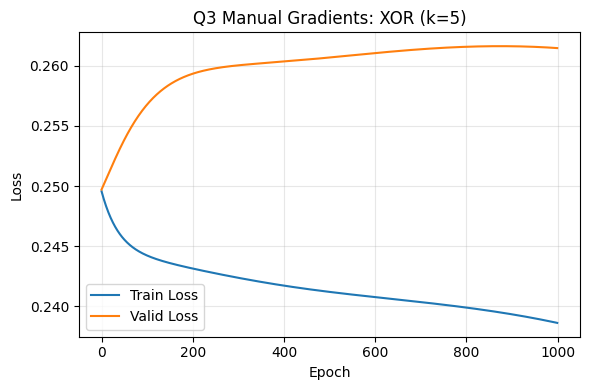

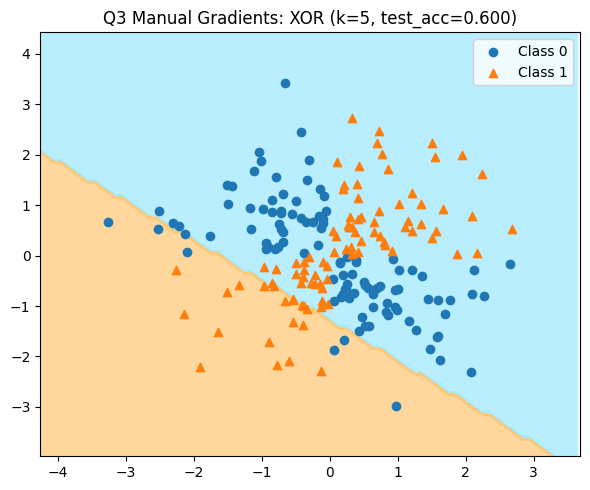

In [6]:
# evaluate manual MLP on XOR dataset

print("=" * 60)
print("QUESTION 3: Manual Gradients on XOR Dataset")
print("=" * 60)

# Load XOR dataset
datasets = load_datasets('xor')
X_train, y_train = datasets['train']
X_valid, y_valid = datasets['valid']
X_test, y_test = datasets['test']

# Convert to numpy
X_train_np = X_train.numpy()
y_train_np = y_train.numpy().astype(float)
X_valid_np = X_valid.numpy()
y_valid_np = y_valid.numpy().astype(float)
X_test_np = X_test.numpy()
y_test_np = y_test.numpy()

# Train manual MLP
print("\nTraining manual MLP with k=5 hidden nodes...")
manual_model, train_losses, valid_losses = train_manual_mlp(
    X_train_np, y_train_np, X_valid_np, y_valid_np,
    hidden_dim=5, lr=0.1, epochs=1000
)

# Evaluate on test set
test_predictions = manual_model.predict(X_test_np)
test_acc = np.mean(test_predictions == y_test_np)

print(f"\n{'*'*60}")
print(f"Manual MLP Test Accuracy: {test_acc:.4f}")
print(f"{'*'*60}")

# Plot learning curves
plot_learning_curves(
    train_losses, valid_losses,
    title='Q3 Manual Gradients: XOR (k=5)'
)

# Plot decision surface
bounds = compute_bounds(X_test_np)
wrapper = ManualMLPWrapper(manual_model)
plot_decision_surface(
    X_test_np, y_test_np, wrapper, bounds,
    title=f'Q3 Manual Gradients: XOR (k=5, test_acc={test_acc:.3f})'
)


<h1>Orthogonality Regularizer</h1>

In [12]:
# model w/ MSE
class MLP_MSE(nn.Module):
    """Multi-layer Perceptron for classification with MSE loss."""
    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.output_activation = nn.Sigmoid()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.activation(self.fc1(x))
        logit = self.fc2(h)
        prob = self.output_activation(logit).squeeze(-1)
        return prob

class MLP_MSE(nn.Module):
    """Multi-layer Perceptron for classification with MSE loss."""
    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.output_activation = nn.Sigmoid()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.activation(self.fc1(x))
        logit = self.fc2(h)
        prob = self.output_activation(logit).squeeze(-1)
        return prob


def train_mse(datasets: Dict, hidden_dim: int, lr: float = 0.01,
              epochs: int = 500, batch_size: int = 32) -> Tuple:
    """Train MLP with MSE loss."""
    X_train, y_train = datasets['train']
    X_valid, y_valid = datasets['valid']
    
    # Convert labels to float for MSE
    y_train_f = y_train.float()
    y_valid_f = y_valid.float()
    
    model = MLP_MSE(input_dim=2, hidden_dim=hidden_dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    train_losses, valid_losses = [], []
    n = X_train.shape[0]
    
    for epoch in range(epochs):
        # Training
        model.train()
        indices = torch.randperm(n)
        
        for i in range(0, n, batch_size):
            batch_idx = indices[i:min(i+batch_size, n)]
            X_batch = X_train[batch_idx]
            y_batch = y_train_f[batch_idx]
            
            optimizer.zero_grad()
            probs = model(X_batch)
            loss = criterion(probs, y_batch)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            train_loss = criterion(model(X_train), y_train_f).item()
            valid_loss = criterion(model(X_valid), y_valid_f).item()
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
    
    return model, train_losses, valid_losses


def evaluate_mse(model: MLP_MSE, X: torch.Tensor, y: torch.Tensor) -> float:
    """Evaluate accuracy of MSE model."""
    model.eval()
    with torch.no_grad():
        probs = model(X)
        predictions = (probs > 0.5).long()
        accuracy = (predictions == y).float().mean().item()
    return accuracy


class MSEWrapper:
    """Wrapper for plotting decision surfaces."""
    def __init__(self, model: MLP_MSE):
        self.model = model
        self.model.eval()
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            probs = self.model(X_tensor)
            predictions = (probs > 0.5).long().numpy()
        return predictions



In [13]:

def orthogonality_penalty(W: torch.Tensor) -> torch.Tensor:
    """Compute orthogonality penalty: ||W @ W^T -I||_F^2"""
    WWT = W @ W.t()
    I = torch.eye(WWT.shape[0], device=W.device, dtype=W.dtype)
    penalty = torch.norm(WWT - I, p='fro') ** 2
    return penalty


def train_mse_with_regularization(datasets: Dict, hidden_dim: int, 
                                 lambda_reg: float = 0.1,
                                 lr: float = 0.01, epochs: int = 500,
                                 batch_size: int = 32) -> Tuple:
    """Train MSE model with orthogonality regularization."""
    X_train, y_train = datasets['train']
    X_valid, y_valid = datasets['valid']
    
    y_train_f = y_train.float()
    y_valid_f = y_valid.float()
    
    model = MLP_MSE(input_dim=2, hidden_dim=hidden_dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    train_losses, valid_losses = [], []
    n = X_train.shape[0]
    
    for epoch in range(epochs):
        # Training
        model.train()
        indices = torch.randperm(n)
        
        for i in range(0, n, batch_size):
            batch_idx = indices[i:min(i+batch_size, n)]
            X_batch = X_train[batch_idx]
            y_batch = y_train_f[batch_idx]
            
            optimizer.zero_grad()
            probs = model(X_batch)

            # Total loss = MSE loss + regularization penalty
            mse_loss = criterion(probs, y_batch)
            reg_penalty = orthogonality_penalty(model.fc1.weight)
            total_loss = mse_loss + lambda_reg * reg_penalty
            
            total_loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            train_mse = criterion(model(X_train), y_train_f)
            train_reg = orthogonality_penalty(model.fc1.weight)
            train_loss = (train_mse + lambda_reg * train_reg).item()
            
            valid_mse = criterion(model(X_valid), y_valid_f)
            valid_reg = orthogonality_penalty(model.fc1.weight)
            valid_loss = (valid_mse + lambda_reg * valid_reg).item()
            
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
    
    return model, train_losses, valid_losses


class HiddenNodeWrapper:
    """Wrapper to visualize individual hidden node decision boundaries."""
    def __init__(self, model: MLP_MSE, node_idx: int):
        self.W = model.fc1.weight[node_idx].detach().cpu().numpy()
        self.b = model.fc1.bias[node_idx].detach().cpu().numpy()
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        # Linear decision: W @ X + b
        # Predict 1 if z > 0, else 0
        z = X @ self.W + self.b
        return (z > 0).astype(int)

QUESTION 4: Orthogonality Regularizer on XOR (k=3)

Training UNREGULARIZED model (k=3)...
Unregularized Test Accuracy: 0.6950

Training REGULARIZED model (k=3, lambda=0.1)...
Regularized Test Accuracy: 0.8600

************************************************************
Unregularized Test Acc: 0.6950
Regularized Test Acc: 0.8600
************************************************************


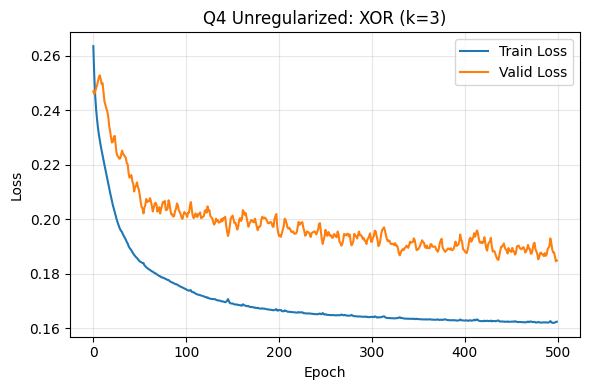

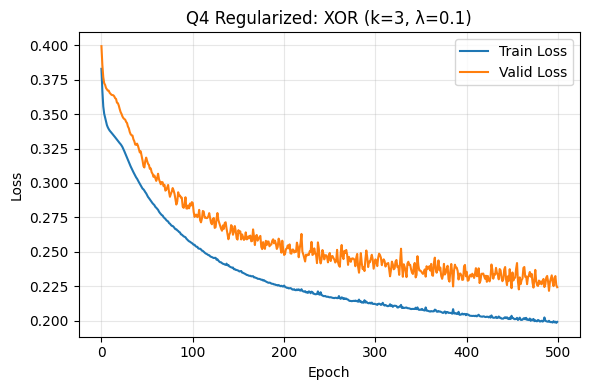

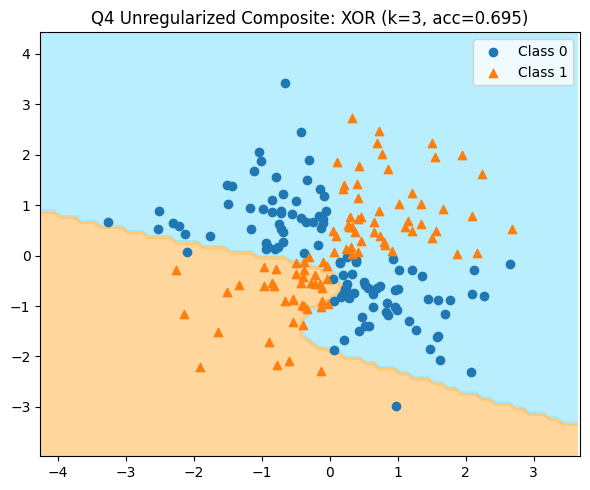

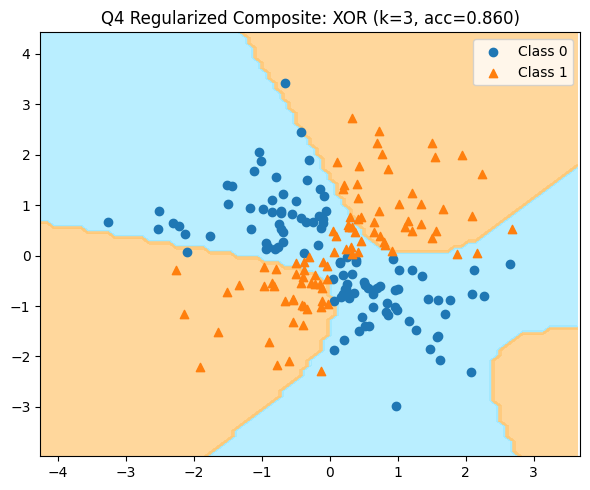


Plotting individual hidden node decision boundaries...


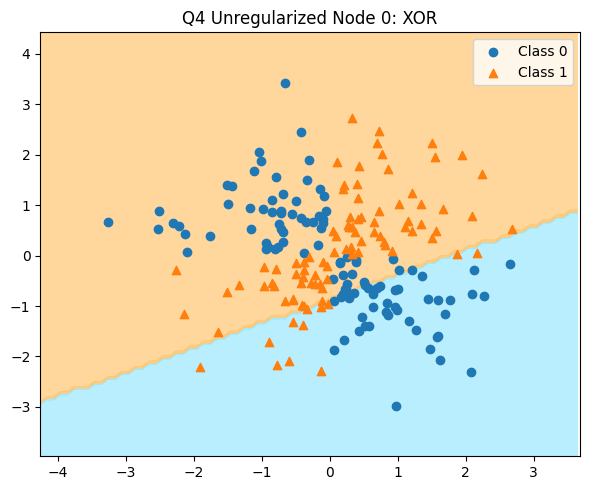

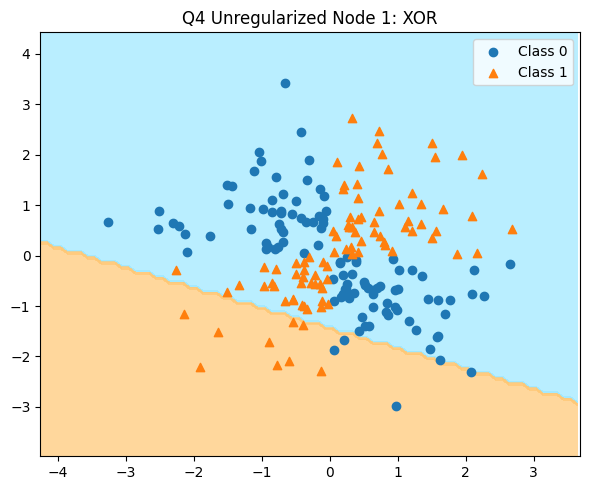

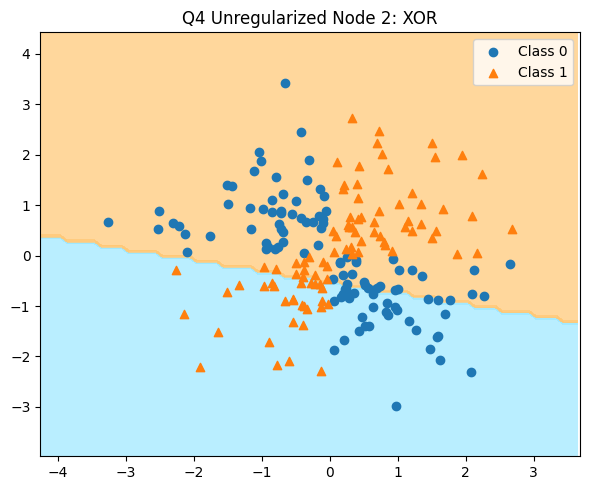

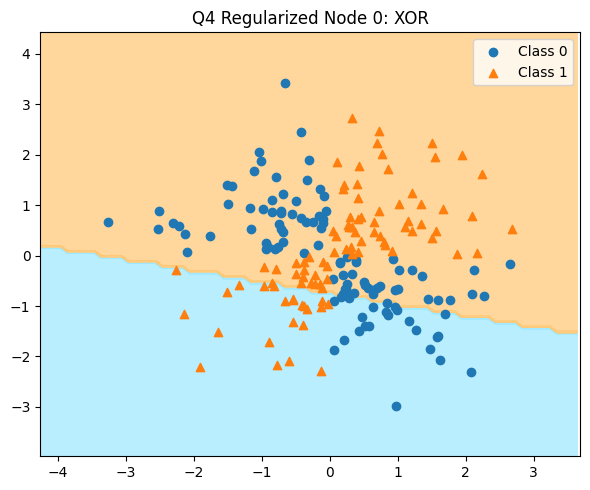

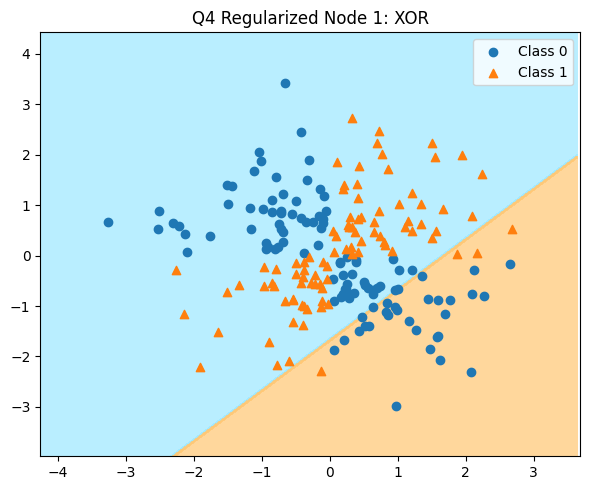

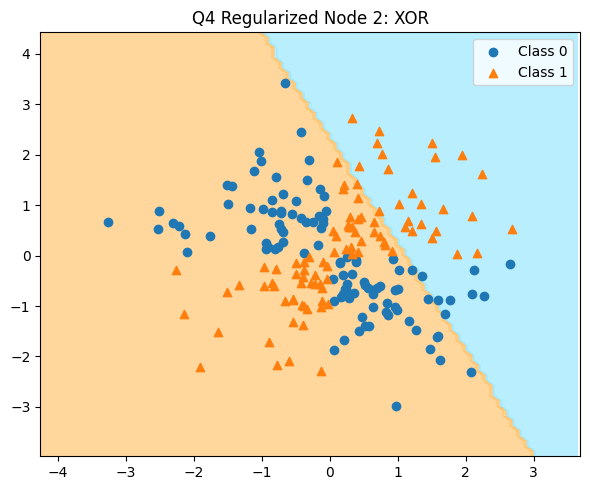


between regularized and unregularized models.


In [15]:
# Compare regularized vs unregularized models on XOR

print("=" * 60)
print("QUESTION 4: Orthogonality Regularizer on XOR (k=3)")
print("=" * 60)

# Load XOR dataset
datasets = load_datasets('xor')
X_test, y_test = datasets['test']
X_test_np = X_test.numpy()
y_test_np = y_test.numpy()
bounds = compute_bounds(X_test_np)

k = 3
lambda_reg = 0.1

# Train unregularized model
print(f"\nTraining UNREGULARIZED model (k={k})...")
model_unreg, train_losses_unreg, valid_losses_unreg = train_mse(
    datasets, hidden_dim=k, lr=0.01, epochs=500, batch_size=32
)
test_acc_unreg = evaluate_mse(model_unreg, X_test, y_test)
print(f"Unregularized Test Accuracy: {test_acc_unreg:.4f}")

# Train regularized model
print(f"\nTraining REGULARIZED model (k={k}, lambda={lambda_reg})...")
model_reg, train_losses_reg, valid_losses_reg = train_mse_with_regularization(
    datasets, hidden_dim=k, lambda_reg=lambda_reg, lr=0.01, epochs=500, batch_size=32
)
test_acc_reg = evaluate_mse(model_reg, X_test, y_test)
print(f"Regularized Test Accuracy: {test_acc_reg:.4f}")

print(f"\n{'*'*60}")
print(f"Unregularized Test Acc: {test_acc_unreg:.4f}")
print(f"Regularized Test Acc: {test_acc_reg:.4f}")
print(f"{'*'*60}")

# Plot learning curves
plot_learning_curves(
    train_losses_unreg, valid_losses_unreg,
    title=f'Q4 Unregularized: XOR (k={k})'
)
plot_learning_curves(
    train_losses_reg, valid_losses_reg,
    title=f'Q4 Regularized: XOR (k={k}, λ={lambda_reg})'
)

# Plot composite decision surfaces
wrapper_unreg = MSEWrapper(model_unreg)
plot_decision_surface(
    X_test_np, y_test_np, wrapper_unreg, bounds,
    title=f'Q4 Unregularized Composite: XOR (k={k}, acc={test_acc_unreg:.3f})'
)

wrapper_reg = MSEWrapper(model_reg)
plot_decision_surface(
    X_test_np, y_test_np, wrapper_reg, bounds,
    title=f'Q4 Regularized Composite: XOR (k={k}, acc={test_acc_reg:.3f})'
)

# Plot individual hidden node decision boundaries
print("\nPlotting individual hidden node decision boundaries...")

for node_idx in range(k):
    wrapper_node_unreg = HiddenNodeWrapper(model_unreg, node_idx)
    plot_decision_surface(
        X_test_np, y_test_np, wrapper_node_unreg, bounds,
        title=f'Q4 Unregularized Node {node_idx}: XOR'
    )

for node_idx in range(k):
    wrapper_node_reg = HiddenNodeWrapper(model_reg, node_idx)
    plot_decision_surface(
        X_test_np, y_test_np, wrapper_node_reg, bounds,
        title=f'Q4 Regularized Node {node_idx}: XOR'
    )

print("\n" + "="*60)
print("between regularized and unregularized models.")
print("="*60)
